In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [3]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.12),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.12),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [4]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 237837, Validation Loss: 233567, 16088.987721204141
Epoch 101, Training Loss: 79267, Validation Loss: 74937, 56038.374050600476
Epoch 201, Training Loss: 63992, Validation Loss: 63848, 148909.89249542562
Epoch 301, Training Loss: 61666, Validation Loss: 58373, 160549.10161126804
Epoch 401, Training Loss: 61064, Validation Loss: 63088, 206048.01006451095
Epoch 501, Training Loss: 57163, Validation Loss: 56238, 121615.26958535962
Epoch 601, Training Loss: 53673, Validation Loss: 55349, 115536.48968533461
Epoch 701, Training Loss: 56179, Validation Loss: 54369, 236018.80009538322
Epoch 801, Training Loss: 54426, Validation Loss: 54327, 70460.21394255779
Epoch 901, Training Loss: 52874, Validation Loss: 53626, 112942.93390291267
Epoch 1001, Training Loss: 56292, Validation Loss: 54136, 165994.35355415978
Epoch 1101, Training Loss: 54874, Validation Loss: 52719, 106310.0986500975
Epoch 1201, Training Loss: 52260, Validation Loss: 55126, 182535.5019237129
Epoch 1301, 

Epoch 10701, Training Loss: 45859, Validation Loss: 49896, 132964.26940115428
Epoch 10801, Training Loss: 44340, Validation Loss: 52332, 206678.99649995603
Epoch 10901, Training Loss: 47079, Validation Loss: 50035, 216446.3653580212
Epoch 11001, Training Loss: 48553, Validation Loss: 52653, 316052.2452006159
Epoch 11101, Training Loss: 43697, Validation Loss: 52440, 167922.52541597592
Epoch 11201, Training Loss: 42063, Validation Loss: 49939, 165013.17514354948
Epoch 11301, Training Loss: 44848, Validation Loss: 50325, 236126.87477939916
Epoch 11401, Training Loss: 44080, Validation Loss: 49670, 132786.3012566334
Epoch 11501, Training Loss: 47186, Validation Loss: 49480, 205966.24487423128
Epoch 11601, Training Loss: 45393, Validation Loss: 49410, 165496.73429690753
Epoch 11701, Training Loss: 45937, Validation Loss: 50320, 230090.06637714882
Epoch 11801, Training Loss: 44264, Validation Loss: 49752, 124097.17667277617
Epoch 11901, Training Loss: 47127, Validation Loss: 48432, 142587.1

Epoch 21301, Training Loss: 44869, Validation Loss: 53818, 198533.65504591414
Epoch 21401, Training Loss: 41677, Validation Loss: 51083, 144417.58217667823
Epoch 21501, Training Loss: 44230, Validation Loss: 52290, 196634.91423859564
Epoch 21601, Training Loss: 41543, Validation Loss: 51293, 229770.64337665285
Epoch 21701, Training Loss: 41602, Validation Loss: 51178, 191906.95763528708
Epoch 21801, Training Loss: 40411, Validation Loss: 51138, 181618.666075225
Epoch 21901, Training Loss: 43084, Validation Loss: 50271, 178611.2284980643
Epoch 22001, Training Loss: 43056, Validation Loss: 54574, 191531.0951397495
Epoch 22101, Training Loss: 47515, Validation Loss: 49760, 278020.88426418643
Epoch 22201, Training Loss: 45112, Validation Loss: 50878, 242203.40468684013
Epoch 22301, Training Loss: 42277, Validation Loss: 53898, 227706.66821297767
Epoch 22401, Training Loss: 39244, Validation Loss: 50414, 132461.46542386003
Epoch 22501, Training Loss: 44880, Validation Loss: 53885, 225791.74

Epoch 31901, Training Loss: 38624, Validation Loss: 51391, 152745.7045088301
Epoch 32001, Training Loss: 40214, Validation Loss: 53070, 146896.98274764462
Epoch 32101, Training Loss: 39879, Validation Loss: 49877, 131939.10090751084
Epoch 32201, Training Loss: 37851, Validation Loss: 53936, 176709.15267024786
Epoch 32301, Training Loss: 38627, Validation Loss: 51968, 184745.89902532267
Epoch 32401, Training Loss: 38122, Validation Loss: 52349, 177716.78897844852
Epoch 32501, Training Loss: 41250, Validation Loss: 51840, 119872.74013933638
Epoch 32601, Training Loss: 37614, Validation Loss: 55046, 236010.46424295558
Epoch 32701, Training Loss: 41274, Validation Loss: 50711, 187058.47492742888
Epoch 32801, Training Loss: 40707, Validation Loss: 53979, 230352.5108681327
Epoch 32901, Training Loss: 40867, Validation Loss: 52307, 233617.9858941563
Epoch 33001, Training Loss: 38359, Validation Loss: 53183, 179126.7579034448
Epoch 33101, Training Loss: 38256, Validation Loss: 50152, 159758.59

Epoch 42501, Training Loss: 38506, Validation Loss: 50614, 210102.2123925436
Epoch 42601, Training Loss: 37612, Validation Loss: 48298, 224255.07188086247
Epoch 42701, Training Loss: 39518, Validation Loss: 55452, 211934.534604772
Epoch 42801, Training Loss: 37036, Validation Loss: 53536, 165038.28041661214
Epoch 42901, Training Loss: 38846, Validation Loss: 52966, 268321.40293559065
Epoch 43001, Training Loss: 38651, Validation Loss: 54019, 262841.5887730368
Epoch 43101, Training Loss: 38043, Validation Loss: 53616, 126235.35632200162
Epoch 43201, Training Loss: 39102, Validation Loss: 51452, 209899.8634001217
Epoch 43301, Training Loss: 37683, Validation Loss: 49748, 184941.0690396769
Epoch 43401, Training Loss: 36885, Validation Loss: 52482, 186088.58799084343
Epoch 43501, Training Loss: 37863, Validation Loss: 52316, 236704.19014661582
Epoch 43601, Training Loss: 38814, Validation Loss: 53450, 177812.84869787647
Epoch 43701, Training Loss: 39340, Validation Loss: 56626, 207580.3953

Epoch 53101, Training Loss: 36299, Validation Loss: 52727, 194622.45140569317
Epoch 53201, Training Loss: 37850, Validation Loss: 53070, 127764.73659997864
Epoch 53301, Training Loss: 39876, Validation Loss: 56351, 167648.81260453584
Epoch 53401, Training Loss: 38286, Validation Loss: 51226, 227198.23809827157
Epoch 53501, Training Loss: 36588, Validation Loss: 51137, 186030.57638293752
Epoch 53601, Training Loss: 36687, Validation Loss: 53991, 203680.44512218263
Epoch 53701, Training Loss: 39598, Validation Loss: 54945, 236827.39210624062
Epoch 53801, Training Loss: 38593, Validation Loss: 52627, 134855.69208623294
Epoch 53901, Training Loss: 37747, Validation Loss: 56209, 234262.11578799642
Epoch 54001, Training Loss: 40541, Validation Loss: 53410, 192333.35105126115
Epoch 54101, Training Loss: 36310, Validation Loss: 51999, 183682.698774077
Epoch 54201, Training Loss: 38939, Validation Loss: 53249, 183334.68873215094
Epoch 54301, Training Loss: 37624, Validation Loss: 54543, 121017.

Epoch 63701, Training Loss: 38275, Validation Loss: 54070, 168993.2619621067
Epoch 63801, Training Loss: 37671, Validation Loss: 53496, 218372.83878678977
Epoch 63901, Training Loss: 37983, Validation Loss: 56236, 174775.64125121455
Epoch 64001, Training Loss: 37217, Validation Loss: 53220, 134358.47815702602
Epoch 64101, Training Loss: 38785, Validation Loss: 57074, 158094.13381659196
Epoch 64201, Training Loss: 35990, Validation Loss: 50992, 138710.70251978596
Epoch 64301, Training Loss: 37541, Validation Loss: 54467, 151101.12383394092
Epoch 64401, Training Loss: 37072, Validation Loss: 54590, 195555.73656586884
Epoch 64501, Training Loss: 35902, Validation Loss: 56515, 177567.8817210649
Epoch 64601, Training Loss: 34517, Validation Loss: 55094, 201961.55136012522
Epoch 64701, Training Loss: 36156, Validation Loss: 54644, 135103.1917616722
Epoch 64801, Training Loss: 34872, Validation Loss: 56225, 179422.23087067457
Epoch 64901, Training Loss: 37064, Validation Loss: 52217, 165473.4

Epoch 74301, Training Loss: 35626, Validation Loss: 53872, 157258.90540202867
Epoch 74401, Training Loss: 34068, Validation Loss: 54413, 176516.4601032883
Epoch 74501, Training Loss: 38138, Validation Loss: 55926, 213355.86942492603
Epoch 74601, Training Loss: 35639, Validation Loss: 53388, 177165.4532257476
Epoch 74701, Training Loss: 36967, Validation Loss: 53656, 171871.93609879966
Epoch 74801, Training Loss: 39544, Validation Loss: 54596, 202976.38990961903
Epoch 74901, Training Loss: 35237, Validation Loss: 52994, 169833.38681457515
Epoch 75001, Training Loss: 37451, Validation Loss: 55025, 185703.80090898994
Epoch 75101, Training Loss: 37188, Validation Loss: 55375, 180809.15966988253
Epoch 75201, Training Loss: 33964, Validation Loss: 54757, 157432.36394998283
Epoch 75301, Training Loss: 34818, Validation Loss: 53269, 161960.66025914144
Epoch 75401, Training Loss: 37037, Validation Loss: 52455, 154399.5465877788
Epoch 75501, Training Loss: 35768, Validation Loss: 54814, 182516.7

Epoch 84901, Training Loss: 34625, Validation Loss: 60423, 141232.30456760607
Epoch 85001, Training Loss: 35546, Validation Loss: 58886, 157388.69161117545
Epoch 85101, Training Loss: 38406, Validation Loss: 54328, 171282.98958197143
Epoch 85201, Training Loss: 35106, Validation Loss: 52811, 168054.22296936842
Epoch 85301, Training Loss: 33834, Validation Loss: 54689, 138666.88887361516
Epoch 85401, Training Loss: 36416, Validation Loss: 52072, 159447.38827732365
Epoch 85501, Training Loss: 34559, Validation Loss: 53240, 135069.13698472813
Epoch 85601, Training Loss: 37118, Validation Loss: 53367, 215293.21148745585
Epoch 85701, Training Loss: 38469, Validation Loss: 53907, 230849.08327927996
Epoch 85801, Training Loss: 35256, Validation Loss: 55221, 171947.6388851153
Epoch 85901, Training Loss: 36528, Validation Loss: 53036, 153202.84201975117
Epoch 86001, Training Loss: 36588, Validation Loss: 50638, 171047.4688776123
Epoch 86101, Training Loss: 38221, Validation Loss: 55623, 166039.

Epoch 95501, Training Loss: 34622, Validation Loss: 52354, 184212.63888434405
Epoch 95601, Training Loss: 36579, Validation Loss: 54703, 192204.68462544915
Epoch 95701, Training Loss: 37988, Validation Loss: 55694, 139116.9859180564
Epoch 95801, Training Loss: 37403, Validation Loss: 54991, 159428.79782636746
Epoch 95901, Training Loss: 38780, Validation Loss: 55057, 173854.12085162164
Epoch 96001, Training Loss: 33702, Validation Loss: 56490, 116088.55977520232
Epoch 96101, Training Loss: 33426, Validation Loss: 56091, 155574.2247841934
Epoch 96201, Training Loss: 34601, Validation Loss: 54426, 133756.20357647285
Epoch 96301, Training Loss: 36625, Validation Loss: 52653, 148447.89288219536
Epoch 96401, Training Loss: 37110, Validation Loss: 54912, 210915.29436624734
Epoch 96501, Training Loss: 40317, Validation Loss: 55090, 293602.10088234424
Epoch 96601, Training Loss: 36029, Validation Loss: 55803, 182713.8671292487
Epoch 96701, Training Loss: 35156, Validation Loss: 53870, 175008.5

Epoch 106001, Training Loss: 34121, Validation Loss: 56853, 185924.51092231402
Epoch 106101, Training Loss: 36913, Validation Loss: 54081, 203022.19686855856
Epoch 106201, Training Loss: 33560, Validation Loss: 53810, 217271.7425007976
Epoch 106301, Training Loss: 35230, Validation Loss: 54787, 170475.1592440886
Epoch 106401, Training Loss: 32247, Validation Loss: 57158, 158672.65834887236
Epoch 106501, Training Loss: 37405, Validation Loss: 56643, 143621.1684397798
Epoch 106601, Training Loss: 36638, Validation Loss: 54290, 177038.65696294303
Epoch 106701, Training Loss: 35686, Validation Loss: 55095, 146171.13564334202
Epoch 106801, Training Loss: 35037, Validation Loss: 54041, 178460.89833618325
Epoch 106901, Training Loss: 35892, Validation Loss: 54397, 228919.99367147838
Epoch 107001, Training Loss: 35187, Validation Loss: 54620, 196031.12394163234
Epoch 107101, Training Loss: 37108, Validation Loss: 58065, 182803.14494541532
Epoch 107201, Training Loss: 37884, Validation Loss: 53

Epoch 116501, Training Loss: 33519, Validation Loss: 54693, 133233.57035458172
Epoch 116601, Training Loss: 33920, Validation Loss: 58048, 174796.428326617
Epoch 116701, Training Loss: 33968, Validation Loss: 55409, 223444.4115787011
Epoch 116801, Training Loss: 34050, Validation Loss: 55402, 165494.97330491993
Epoch 116901, Training Loss: 34999, Validation Loss: 53726, 147871.5630301922
Epoch 117001, Training Loss: 32560, Validation Loss: 54665, 145908.98603043918
Epoch 117101, Training Loss: 33065, Validation Loss: 55269, 117501.53930760403
Epoch 117201, Training Loss: 34984, Validation Loss: 55699, 166569.40459159552
Epoch 117301, Training Loss: 34481, Validation Loss: 56678, 198415.09957591063
Epoch 117401, Training Loss: 35578, Validation Loss: 51671, 183696.40469544768
Epoch 117501, Training Loss: 36899, Validation Loss: 54791, 218480.39323483044
Epoch 117601, Training Loss: 35531, Validation Loss: 54709, 112121.5106060491
Epoch 117701, Training Loss: 35689, Validation Loss: 5508

Epoch 127001, Training Loss: 33016, Validation Loss: 56153, 162179.9615167108
Epoch 127101, Training Loss: 38210, Validation Loss: 54616, 225672.68601055336
Epoch 127201, Training Loss: 35014, Validation Loss: 57670, 176654.13068747878
Epoch 127301, Training Loss: 39451, Validation Loss: 54912, 156077.03544613326
Epoch 127401, Training Loss: 33360, Validation Loss: 56274, 154068.41096314494
Epoch 127501, Training Loss: 35214, Validation Loss: 55766, 204174.12072051773
Epoch 127601, Training Loss: 33933, Validation Loss: 56432, 138330.81983789522
Epoch 127701, Training Loss: 35015, Validation Loss: 52901, 245857.88148125992
Epoch 127801, Training Loss: 37329, Validation Loss: 58342, 151717.24861265274
Epoch 127901, Training Loss: 35881, Validation Loss: 53273, 172510.5285050501
Epoch 128001, Training Loss: 35336, Validation Loss: 56414, 170743.1829686278
Epoch 128101, Training Loss: 36024, Validation Loss: 55137, 161714.42666182327
Epoch 128201, Training Loss: 33749, Validation Loss: 56

Epoch 137501, Training Loss: 35034, Validation Loss: 55945, 190688.57616194125
Epoch 137601, Training Loss: 32821, Validation Loss: 57351, 151335.36434822273
Epoch 137701, Training Loss: 34234, Validation Loss: 52613, 195209.28576405635
Epoch 137801, Training Loss: 35023, Validation Loss: 57639, 165539.9294724605
Epoch 137901, Training Loss: 37019, Validation Loss: 56136, 304157.91148916114
Epoch 138001, Training Loss: 34529, Validation Loss: 57662, 160143.9571994266
Epoch 138101, Training Loss: 35382, Validation Loss: 55641, 173036.60369608004
Epoch 138201, Training Loss: 34168, Validation Loss: 55872, 215769.71001771992
Epoch 138301, Training Loss: 33753, Validation Loss: 54078, 136378.4117780556
Epoch 138401, Training Loss: 35979, Validation Loss: 55642, 170642.27562378792
Epoch 138501, Training Loss: 33052, Validation Loss: 54109, 127901.42599317594
Epoch 138601, Training Loss: 36968, Validation Loss: 57003, 182636.8587096047
Epoch 138701, Training Loss: 34058, Validation Loss: 564

Epoch 148001, Training Loss: 34135, Validation Loss: 57117, 145195.45067414994
Epoch 148101, Training Loss: 35295, Validation Loss: 55283, 153872.03815209263
Epoch 148201, Training Loss: 33367, Validation Loss: 54762, 138062.10486432665
Epoch 148301, Training Loss: 34112, Validation Loss: 57387, 129422.25707404804
Epoch 148401, Training Loss: 33199, Validation Loss: 56007, 169115.17063201082
Epoch 148501, Training Loss: 35265, Validation Loss: 58359, 195049.03853510585
Epoch 148601, Training Loss: 35721, Validation Loss: 54362, 178147.88977858948
Epoch 148701, Training Loss: 37041, Validation Loss: 54171, 151369.1188831291
Epoch 148801, Training Loss: 34673, Validation Loss: 55661, 142290.40405535986
Epoch 148901, Training Loss: 32200, Validation Loss: 56055, 155626.75540702534
Epoch 149001, Training Loss: 33688, Validation Loss: 55644, 137825.67966383244
Epoch 149101, Training Loss: 34780, Validation Loss: 57893, 169388.01788809884
Epoch 149201, Training Loss: 34540, Validation Loss: 

Epoch 158501, Training Loss: 32551, Validation Loss: 56339, 246852.12715698392
Epoch 158601, Training Loss: 34187, Validation Loss: 55763, 146831.18218937877
Epoch 158701, Training Loss: 34466, Validation Loss: 53241, 173353.95971166552
Epoch 158801, Training Loss: 33971, Validation Loss: 55960, 132820.94147097904
Epoch 158901, Training Loss: 35488, Validation Loss: 52370, 210668.5990451672
Epoch 159001, Training Loss: 31838, Validation Loss: 55155, 137079.02678673956
Epoch 159101, Training Loss: 33887, Validation Loss: 54139, 162643.42648265345
Epoch 159201, Training Loss: 33006, Validation Loss: 53560, 114282.59980337632
Epoch 159301, Training Loss: 33293, Validation Loss: 56476, 124204.41512558966
Epoch 159401, Training Loss: 32336, Validation Loss: 55254, 129261.54887993581
Epoch 159501, Training Loss: 36214, Validation Loss: 52825, 254822.61710940977
Epoch 159601, Training Loss: 35715, Validation Loss: 55197, 135974.3931970007
Epoch 159701, Training Loss: 35832, Validation Loss: 5

Epoch 169001, Training Loss: 36280, Validation Loss: 54747, 139614.70289350854
Epoch 169101, Training Loss: 34675, Validation Loss: 53585, 148068.54008560578
Epoch 169201, Training Loss: 36265, Validation Loss: 56681, 206653.75218791506
Epoch 169301, Training Loss: 35352, Validation Loss: 59443, 207803.3643835551
Epoch 169401, Training Loss: 34567, Validation Loss: 53433, 172802.2696349162
Epoch 169501, Training Loss: 34103, Validation Loss: 55633, 187682.90041086162
Epoch 169601, Training Loss: 33813, Validation Loss: 55223, 170508.66189081877
Epoch 169701, Training Loss: 31760, Validation Loss: 58085, 168166.3779487676
Epoch 169801, Training Loss: 34414, Validation Loss: 55934, 166435.6672194472
Epoch 169901, Training Loss: 33880, Validation Loss: 56454, 124865.85126245006
Epoch 170001, Training Loss: 36726, Validation Loss: 54380, 143799.36290868852
Epoch 170101, Training Loss: 35106, Validation Loss: 55052, 184175.95167277
Epoch 170201, Training Loss: 33231, Validation Loss: 55869,

Epoch 179501, Training Loss: 33055, Validation Loss: 57728, 153984.06878993285
Epoch 179601, Training Loss: 35381, Validation Loss: 55068, 146033.5953833525
Epoch 179701, Training Loss: 34056, Validation Loss: 55636, 162303.70031102397
Epoch 179801, Training Loss: 35215, Validation Loss: 53730, 213168.0273215597
Epoch 179901, Training Loss: 34362, Validation Loss: 56113, 175873.71088524917
Epoch 180001, Training Loss: 37568, Validation Loss: 54870, 199268.46988982058
Epoch 180101, Training Loss: 35597, Validation Loss: 58216, 208737.43694143847
Epoch 180201, Training Loss: 34250, Validation Loss: 52806, 125702.30112071364
Epoch 180301, Training Loss: 34745, Validation Loss: 56626, 166914.67399596775
Epoch 180401, Training Loss: 37040, Validation Loss: 55966, 168312.99382172013
Epoch 180501, Training Loss: 34609, Validation Loss: 54196, 156217.6751404321
Epoch 180601, Training Loss: 38400, Validation Loss: 55315, 177325.54729235618
Epoch 180701, Training Loss: 33968, Validation Loss: 56

Epoch 190001, Training Loss: 36486, Validation Loss: 53305, 145649.09521149602
Epoch 190101, Training Loss: 38098, Validation Loss: 55907, 146362.12948352157
Epoch 190201, Training Loss: 34427, Validation Loss: 54655, 136787.7993302584
Epoch 190301, Training Loss: 34739, Validation Loss: 54303, 159205.6134921692
Epoch 190401, Training Loss: 35757, Validation Loss: 54227, 165632.6126118708
Epoch 190501, Training Loss: 34630, Validation Loss: 56727, 126975.32505242973
Epoch 190601, Training Loss: 36826, Validation Loss: 54192, 135933.26609628045
Epoch 190701, Training Loss: 38143, Validation Loss: 55864, 223422.69601314855
Epoch 190801, Training Loss: 34630, Validation Loss: 56085, 155219.2274365793
Epoch 190901, Training Loss: 33704, Validation Loss: 55894, 169321.54560166935
Epoch 191001, Training Loss: 34539, Validation Loss: 59752, 176684.53839065935
Epoch 191101, Training Loss: 33927, Validation Loss: 52973, 168461.5110158401
Epoch 191201, Training Loss: 34997, Validation Loss: 5469

Epoch 200501, Training Loss: 32359, Validation Loss: 53502, 123181.47729321546
Epoch 200601, Training Loss: 34409, Validation Loss: 59200, 135565.47140781445
Epoch 200701, Training Loss: 37763, Validation Loss: 54243, 105533.16277578923
Epoch 200801, Training Loss: 32678, Validation Loss: 56895, 137537.10800856352
Epoch 200901, Training Loss: 33642, Validation Loss: 54212, 163364.6709218851
Epoch 201001, Training Loss: 35973, Validation Loss: 58738, 201075.83800767464
Epoch 201101, Training Loss: 35174, Validation Loss: 55743, 150054.46379246304
Epoch 201201, Training Loss: 34498, Validation Loss: 53345, 163625.58586351134
Epoch 201301, Training Loss: 36624, Validation Loss: 55692, 134655.64023204133
Epoch 201401, Training Loss: 36239, Validation Loss: 54167, 130118.64600290272
Epoch 201501, Training Loss: 33798, Validation Loss: 59122, 124964.01652327315
Epoch 201601, Training Loss: 32866, Validation Loss: 54213, 120763.04682348784
Epoch 201701, Training Loss: 37546, Validation Loss: 

Epoch 211001, Training Loss: 37221, Validation Loss: 56029, 169129.8636263977
Epoch 211101, Training Loss: 35760, Validation Loss: 55246, 132015.6593676748
Epoch 211201, Training Loss: 36522, Validation Loss: 53900, 152487.22464536165
Epoch 211301, Training Loss: 36502, Validation Loss: 58059, 208369.12135635418
Epoch 211401, Training Loss: 36685, Validation Loss: 56199, 204834.71934289878
Epoch 211501, Training Loss: 36180, Validation Loss: 56479, 172619.47068962283
Epoch 211601, Training Loss: 39337, Validation Loss: 59800, 204715.97684352053
Epoch 211701, Training Loss: 35200, Validation Loss: 57596, 159094.4755310939
Epoch 211801, Training Loss: 32633, Validation Loss: 55416, 129629.76950053248
Epoch 211901, Training Loss: 32750, Validation Loss: 55877, 170710.11675496903
Epoch 212001, Training Loss: 34031, Validation Loss: 54652, 144396.2355942193
Epoch 212101, Training Loss: 37000, Validation Loss: 55042, 112776.12692980653
Epoch 212201, Training Loss: 36869, Validation Loss: 540

Epoch 221501, Training Loss: 38293, Validation Loss: 55009, 199584.88964926233
Epoch 221601, Training Loss: 34930, Validation Loss: 53616, 132572.09945254304
Epoch 221701, Training Loss: 32341, Validation Loss: 55607, 139097.31443380503
Epoch 221801, Training Loss: 34608, Validation Loss: 58916, 153172.4871474266
Epoch 221901, Training Loss: 34565, Validation Loss: 56328, 130619.48549077903
Epoch 222001, Training Loss: 33788, Validation Loss: 57945, 172993.01098832008
Epoch 222101, Training Loss: 37188, Validation Loss: 56664, 188517.73300579193
Epoch 222201, Training Loss: 36222, Validation Loss: 58368, 159415.2751738952
Epoch 222301, Training Loss: 36580, Validation Loss: 54975, 168866.3608128678
Epoch 222401, Training Loss: 37688, Validation Loss: 58986, 183153.34204761553
Epoch 222501, Training Loss: 37460, Validation Loss: 53604, 120714.91408519998
Epoch 222601, Training Loss: 36843, Validation Loss: 55530, 183643.72592472238
Epoch 222701, Training Loss: 36356, Validation Loss: 54

Epoch 232001, Training Loss: 35699, Validation Loss: 54905, 149671.65957747053
Epoch 232101, Training Loss: 34228, Validation Loss: 55684, 146443.52051103205
Epoch 232201, Training Loss: 35988, Validation Loss: 54825, 169092.31931691302
Epoch 232301, Training Loss: 35645, Validation Loss: 55281, 146406.08312573147
Epoch 232401, Training Loss: 33673, Validation Loss: 55731, 167249.12094256532
Epoch 232501, Training Loss: 31978, Validation Loss: 56856, 154759.77392575666
Epoch 232601, Training Loss: 32658, Validation Loss: 55068, 144997.80471321932
Epoch 232701, Training Loss: 37480, Validation Loss: 55984, 225841.96032448622
Epoch 232801, Training Loss: 33923, Validation Loss: 55625, 128453.75951197512
Epoch 232901, Training Loss: 34983, Validation Loss: 55481, 162600.8785969861
Epoch 233001, Training Loss: 33637, Validation Loss: 56159, 113757.45519142128
Epoch 233101, Training Loss: 32626, Validation Loss: 58899, 188855.85508181495
Epoch 233201, Training Loss: 32640, Validation Loss: 

Epoch 242501, Training Loss: 35218, Validation Loss: 55368, 168719.32230121037
Epoch 242601, Training Loss: 34188, Validation Loss: 56184, 183772.4130398465
Epoch 242701, Training Loss: 34825, Validation Loss: 58200, 173387.57583365173
Epoch 242801, Training Loss: 34107, Validation Loss: 55965, 140211.88154726804
Epoch 242901, Training Loss: 34907, Validation Loss: 52968, 174832.79390451722
Epoch 243001, Training Loss: 31784, Validation Loss: 58519, 155869.77175650242
Epoch 243101, Training Loss: 35197, Validation Loss: 54889, 177499.14700574125
Epoch 243201, Training Loss: 35897, Validation Loss: 54061, 184991.58617727147
Epoch 243301, Training Loss: 34871, Validation Loss: 52808, 119758.65213619564
Epoch 243401, Training Loss: 31506, Validation Loss: 54210, 133321.80940617502
Epoch 243501, Training Loss: 34112, Validation Loss: 57699, 133284.49387649566
Epoch 243601, Training Loss: 34237, Validation Loss: 54776, 177306.51154593177
Epoch 243701, Training Loss: 33373, Validation Loss: 

KeyboardInterrupt: 

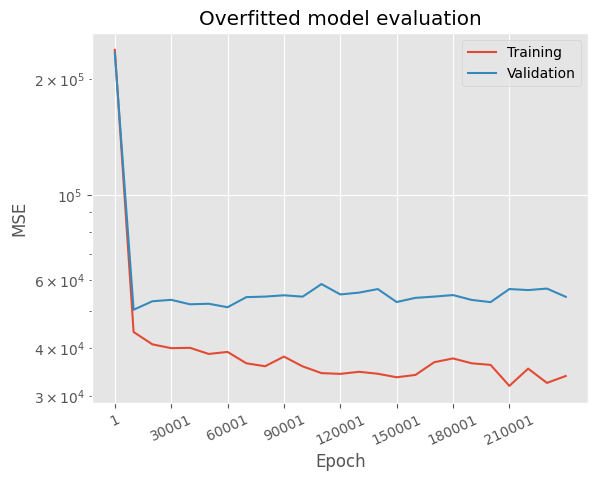

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)